In [179]:
class arab_toolbox:
    
    def __init__(self):
        pass

    def load_pickle(file_path):
        
        import pickle

        text_all_dict = pickle.load( open( file_path, "rb" ) )
        
        print("number of tweets is: " + str(len(text_dicts)))
        
        return text_all_dict
    
    
    def retweet_counts(text_list):
        
        main_text_keys = list(text_dicts.keys())

        list_of_count_dicts = []

        for i in range(0,len(main_text_keys)):

            responses = text_dicts[main_text_keys[i]]["responses"]

            responses_keys = list(responses.keys())

            list_of_count_dicts.append({"retweet_count":len(responses_keys)})

        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns

        count_df = pd.DataFrame(list_of_count_dicts)

        sns.distplot(count_df["retweet_count"])
    
    
    def clean_text_list(text_dicts, thread_level=False, remove_stop=True):
        
        # keys are threads
        
        main_text_keys = list(text_dicts.keys())
        
        # create a list of texts from the json data that contains not just texts
        
        text_list = []
        
        
        
        # thread or not thread level to create the text list
        
        
        if thread_level==True:
            
            for i in range(0,len(main_text_keys)):

                main_tweet = text_dicts[main_text_keys[i]]["main_post"]["text"]

                responses = text_dicts[main_text_keys[i]]["responses"]

                responses_keys = list(responses.keys())

                for response_key in responses_keys:

                    one_response = responses[response_key]["text"]

                    main_tweet = main_tweet+" "+one_response

                    main_tweet = main_tweet.strip()
                    
                text_list.append(main_tweet)

        else:

            for i in range(0,len(main_text_keys)):

                text_list.append(text_dicts[main_text_keys[i]]["main_post"]["text"])
        
        
        # tokenization + stopwords, alphanumeric cleaning

        import nltk

        #nltk.download('punkt')

        from nltk import word_tokenize,sent_tokenize

        # I am removing signs at this point and short words. If stop_words is true then also removing those
        
        if remove_stop==True:
        
            import pickle
            import pandas as pd
            stop_words = pd.read_excel("arab_stop_words.xlsx")["stop_words"].tolist()
            
            def clean(text):
                text_clean_list = [w.strip() for w in word_tokenize(text) if w.isalpha() and w not in stop_words and len(w)>1]
                return text_clean_list
        
        else:
            
            def clean(text):
                text_clean_list = [w.strip() for w in word_tokenize(text) if w.isalpha() and len(w)>1]
                return text_clean_list
        
        text_list = [clean(text) for text in text_list]
        
        return text_list
    
    
    
    def pos_clean(text_list, remove_verbs=True):
        
        import os
        java_path = "C:/Program Files/Java/jdk1.8.0_261/bin/java.exe"
        os.environ['JAVAHOME'] = java_path
        stan_path = "C:/Users/אילנה/Dropbox/jupyter_notebooks/data-science/idc-research/mine/stanford-tagger-4.0.0/"
        
        from nltk.tag.stanford import StanfordPOSTagger as POS_Tag
        
        arabic_postagger = POS_Tag(stan_path+'models/arabic.tagger', stan_path+'/stanford-postagger.jar')
        
        text_list_pos = [arabic_postagger.tag(inner_word_list) for inner_word_list in text_list]
        
        
        if remove_verbs==True:
            
            pos_to_remove = ["VB","VBD","VBG","VBN","VBP","VBZ"]

            text_list_final = []

            for inner_list in text_list_pos:

                final_inner_list = []

                for pos_tuple in inner_list:

                    # sometimes structure is unstable, so need to use find

                    if pos_tuple[0].find("/")>=0:

                        idx=0

                    else:

                        idx=1

                    if pos_tuple[idx].split("/")[1] not in pos_to_remove:           

                        final_inner_list.append(pos_tuple[idx].split("/")[0])

                text_list_final.append(final_inner_list)
                
            else:
                
                text_list_final = text_list
                
                
        return text_list_final
        
    
        
    def create_ngram(text_list_final,threshold="low"):

        # bigram/trigram

        import gensim

        # Build the bigram and trigram models
        # trigram checks for one more word which co-occurs with a bigram.
        bigram = gensim.models.Phrases(text_list_final, min_count=5, threshold=10) # higher threshold fewer phrases.
        trigram = gensim.models.Phrases(bigram[text_list_final], threshold=10)  

        # Faster way to get a sentence clubbed as a trigram/bigram
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        trigram_mod = gensim.models.phrases.Phraser(trigram)


        def make_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        def make_trigrams(texts):
            return [trigram_mod[bigram_mod[doc]] for doc in texts]


        text_list_final = make_bigrams(text_list_final)

        text_list_final = make_trigrams(text_list_final)


        return text_list_final
        
        
    
    def text_list_translator(text_list,language='en'):
        
        import time
        
        # test translator

        from googletrans import Translator

        translator = Translator()
        

        text_list_trans = []

        for i in range(0,len(text_list)):
            
            time.sleep(5)

            inner_translated_list = [translator.translate(w,dest=language).text for w in text_list[i]]

            text_list_trans.append(inner_translated_list)
            
        return text_list_trans
            
    
    def create_bow_corpus(text_list,print=True):
        
        from gensim.corpora.dictionary import Dictionary

        dictionary = Dictionary(text_list)
        
        corpus = [dictionary.doc2bow(doc) for doc in text_list]
        
        return dictionary,corpus
        
    
    
    def buildLDA(dictionary,corpus,num_topics):
        import gensim
        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word = dictionary,
                                                   num_topics=num_topics, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)
        return lda_model
    
    
    
    def lda_vis(lda_model, corpus, dictionary):
    
        # visualize the topics and words

        import pyLDAvis
        import pyLDAvis.gensim  # don't skip this
        import matplotlib.pyplot as plt
        %matplotlib inline

        pyLDAvis.enable_notebook()

        vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

        vis
        
        return vis

In [160]:
def print_bow(dictionary,corpus):
    
    import time
    
    for i in range(0,len(corpus)):
        
        time.sleep(0.1)

        doc = corpus[i]

        doc = sorted(doc, key=lambda w: w[1], reverse=True)


        for word_id, word_count in doc[:10]:

            print(dictionary.get(word_id), word_count)

        print("----------------------------------------")

In [161]:
def print_tfidf(dictionary,corpus):

    from gensim.models.tfidfmodel import TfidfModel

    tfidf = TfidfModel(corpus)
    
    import time
    
    for i in range(0,len(corpus)):
        
        time.sleep(0.1)

        tfidf_weights_doc = tfidf[corpus[i]]

        tfidf_weights_doc_sorted = sorted(tfidf_weights_doc, key=lambda w: w[1], reverse=True)


        for term_id, weight in tfidf_weights_doc_sorted[:10]:

            print(dictionary.get(term_id), weight)

        print("---------------------------------------")

In [146]:
text_dicts = arab_toolbox.load_pickle("concise_intuview_data_tweets_30_7_2020_and_26_8_2020.p")

text_dicts

number of tweets is: 226


{1288191755695861764: {'main_post': {'user_id': 1286202951187529728,
   'created_at': 'Tue Jul 28 19:17:02 +0000 2020',
   'retweets': 113,
   'replies': 56,
   'quotes': 13,
   'text': '🔴 منفذي تفجيرات بئر العبد منذ سبعة أيام،،فلسطينيان من غزة،،من تنظيم ولاية سيناء،،التابع لحركة-"سماح"-الإخوانية الإرهابية-وقد تم تصفيتهما مع ٣٨ تكفيري آخرين',
   'link': 'https://twitter.com/YoussefAdly8/status/1288191755695861764'},
  'responses': {1288239213125742592: {'user_id': 1209570905371922432,
    'created_at': 'Tue Jul 28 22:25:37 +0000 2020',
    'retweets': 0,
    'replies': None,
    'quotes': None,
    'text': 'الله يلعنهم ويلعن حماس والقسام انا عاوزة افهم هما فين من اسرائيل اللي محتله ارضهم هؤلاء بلاشرف ولاكرا…',
    'link': 'https://twitter.com/rowan79019679/status/1288239213125742592'},
   1288246990418202624: {'user_id': 1241306553984135168,
    'created_at': 'Tue Jul 28 22:56:31 +0000 2020',
    'retweets': 0,
    'replies': None,
    'quotes': None,
    'text': 'فلس طينى خاين نجس',
 

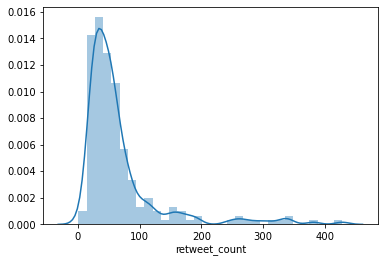

In [147]:
arab_toolbox.retweet_counts(text_list)

In [148]:
text_list = arab_toolbox.clean_text_list(text_dicts, thread_level=False, remove_stop=True)

text_list

[['منفذي',
  'تفجيرات',
  'بئر',
  'العبد',
  'تنظيم',
  'ولاية',
  'سماح',
  'تصفيتهما',
  'تكفيري',
  'آخرين'],
 ['Fact',
  'الأثناء',
  'وصل',
  'وفيات',
  'الأجنة',
  'عبر',
  'الإجهاض',
  'لأكثر',
  'جنين',
  'أشهر',
  'الإجهاض',
  'أكبر',
  'مسبب',
  'للوفيات',
  'إجهاض',
  'جنين',
  'وحدها',
  'بدعم',
  'وتشجيع',
  'الجماعات',
  'النسوية',
  'والليبرالية'],
 ['كطبيب',
  'جلدية',
  'اطرح',
  'رأيي',
  'الشخصي',
  'سيروم',
  'فيتامين',
  'سي',
  'دورة',
  'معالجة',
  'تصبغات',
  'الجلد',
  'نضارته',
  'مقارنة',
  'بكريم',
  'الاكرتين'],
 ['مصدر',
  'خاص',
  'وصول',
  'المدعو',
  'جعفر',
  'يوسف',
  'بور',
  'كبير',
  'مهندسي',
  'الطائرات',
  'المسيرة',
  'الحرس',
  'الثوري',
  'الإيراني',
  'فيلق',
  'القدس',
  'صنعاء',
  'بتوجيهات',
  'مباشرة',
  'قائد',
  'الحرس',
  'الثوري',
  'الإيراني',
  'اللواء',
  'حسين',
  'سلامي'],
 ['السيد',
  'رئيس',
  'المكتب',
  'السياسي',
  'لحركة',
  'حماس',
  'يكشف',
  'لصحيفة',
  'لوسيل',
  'عرض',
  'قدم',
  'للحركة',
  'قوى',
  'كبرى',
  'إثر',

In [149]:
text_list_final = arab_toolbox.pos_clean(text_list, remove_verbs=True)

text_list_final

[['منفذي',
  'تفجيرات',
  'بئر',
  'العبد',
  'تنظيم',
  'ولاية',
  'سماح',
  'تصفيتهما',
  'تكفيري',
  'آخرين'],
 ['Fact',
  'الأثناء',
  'وصل',
  'وفيات',
  'الأجنة',
  'عبر',
  'الإجهاض',
  'لأكثر',
  'جنين',
  'أشهر',
  'الإجهاض',
  'أكبر',
  'مسبب',
  'للوفيات',
  'إجهاض',
  'جنين',
  'وحدها',
  'بدعم',
  'وتشجيع',
  'الجماعات',
  'النسوية',
  'والليبرالية'],
 ['كطبيب',
  'جلدية',
  'اطرح',
  'رأيي',
  'الشخصي',
  'سيروم',
  'فيتامين',
  'سي',
  'دورة',
  'معالجة',
  'تصبغات',
  'الجلد',
  'نضارته',
  'مقارنة',
  'بكريم',
  'الاكرتين'],
 ['مصدر',
  'خاص',
  'وصول',
  'المدعو',
  'جعفر',
  'يوسف',
  'بور',
  'كبير',
  'مهندسي',
  'الطائرات',
  'المسيرة',
  'الحرس',
  'الثوري',
  'الإيراني',
  'فيلق',
  'القدس',
  'صنعاء',
  'بتوجيهات',
  'مباشرة',
  'قائد',
  'الحرس',
  'الثوري',
  'الإيراني',
  'اللواء',
  'حسين',
  'سلامي'],
 ['السيد',
  'رئيس',
  'المكتب',
  'السياسي',
  'لحركة',
  'حماس',
  'يكشف',
  'لصحيفة',
  'لوسيل',
  'عرض',
  'قدم',
  'للحركة',
  'قوى',
  'كبرى',
  'إثر',

In [150]:
text_list_final = arab_toolbox.create_ngram(text_list_final,threshold="low")

text_list_final

[['منفذي',
  'تفجيرات',
  'بئر',
  'العبد',
  'تنظيم',
  'ولاية',
  'سماح',
  'تصفيتهما',
  'تكفيري',
  'آخرين'],
 ['Fact',
  'الأثناء',
  'وصل',
  'وفيات',
  'الأجنة',
  'عبر',
  'الإجهاض',
  'لأكثر',
  'جنين',
  'أشهر',
  'الإجهاض',
  'أكبر',
  'مسبب',
  'للوفيات',
  'إجهاض',
  'جنين',
  'وحدها',
  'بدعم',
  'وتشجيع',
  'الجماعات',
  'النسوية',
  'والليبرالية'],
 ['كطبيب',
  'جلدية',
  'اطرح',
  'رأيي',
  'الشخصي',
  'سيروم',
  'فيتامين',
  'سي',
  'دورة',
  'معالجة',
  'تصبغات',
  'الجلد',
  'نضارته',
  'مقارنة',
  'بكريم',
  'الاكرتين'],
 ['مصدر',
  'خاص',
  'وصول',
  'المدعو',
  'جعفر',
  'يوسف',
  'بور',
  'كبير',
  'مهندسي',
  'الطائرات',
  'المسيرة',
  'الحرس',
  'الثوري',
  'الإيراني',
  'فيلق',
  'القدس',
  'صنعاء',
  'بتوجيهات',
  'مباشرة',
  'قائد',
  'الحرس',
  'الثوري',
  'الإيراني',
  'اللواء',
  'حسين',
  'سلامي'],
 ['السيد',
  'رئيس',
  'المكتب',
  'السياسي',
  'لحركة',
  'حماس',
  'يكشف',
  'لصحيفة',
  'لوسيل',
  'عرض',
  'قدم',
  'للحركة',
  'قوى',
  'كبرى',
  'إثر',

In [140]:
text_list_final_trans = arab_toolbox.text_list_translator(text_list_final,language='en')

In [188]:
#import pickle

#with open("text_list_final_trans.p", "wb") as fp:   #Pickling
#    pickle.dump(text_list_final_trans, fp)

text_list_final_trans

[['Implementers',
  'Explosions',
  'Well',
  'The slave',
  'group',
  'state',
  'Grace',
  'Liquidate them',
  'expiatory',
  'the final'],
 ['Fact',
  'Meantime',
  'Arrive',
  'Mortality',
  'Embryos',
  'Through',
  'Miscarriage',
  'ل .كثر',
  'Embryo',
  'Months',
  'Miscarriage',
  'Larger',
  'Cause',
  'Deaths',
  'miscarriage',
  'More',
  'Embryo',
  'Alone',
  'Supported',
  'And encourage',
  'Groups',
  'Feminism',
  'And liberal'],
 ['As a doctor',
  'Leather',
  'Subtract',
  'My opinion',
  'Profile',
  'Serum',
  'vitamin',
  'C.',
  'Course',
  'Processing',
  'Pigmentation',
  'Skin',
  'Its freshness',
  'Comparison',
  'With cream',
  'Akretin'],
 ['Source',
  'Special',
  'Access',
  'The so called',
  'Jafar',
  'Yousuf',
  'بور',
  'Big',
  'engineering',
  'Planes',
  'The march',
  'the guard',
  'Revolutionary',
  'Iranian',
  'corps',
  'Jerusalem',
  "Sana'a",
  'With directions',
  'directly',
  'Leader',
  'the guard',
  'Revolutionary',
  'Iranian',
 

In [189]:
dictionary,corpus = arab_toolbox.create_bow_corpus(text_list_final_trans,print=True)

In [190]:
print_bow(dictionary,corpus)

Explosions 1
Grace 1
Implementers 1
Liquidate them 1
The slave 1
Well 1
expiatory 1
group 1
state 1
the final 1
----------------------------------------
Embryo 2
Miscarriage 2
Alone 1
And encourage 1
And liberal 1
Arrive 1
Cause 1
Deaths 1
Embryos 1
Fact 1
----------------------------------------
Akretin 1
As a doctor 1
C. 1
Comparison 1
Course 1
Its freshness 1
Leather 1
My opinion 1
Pigmentation 1
Processing 1
----------------------------------------
Iranian 2
Revolutionary 2
the guard 2
Access 1
Big 1
Hussain 1
Jafar 1
Jerusalem 1
Leader 1
Major General 1
----------------------------------------
And take off 1
Devices 1
Effect 1
Foot 1
For a movement 1
For a newspaper 1
Give up 1
Hamas 1
Housed 1
Lucille 1
----------------------------------------
execution 1
party 1
----------------------------------------
Give up 1
And an airport 1
And setting up 1
Folks 1
Gaza 1
Haniyeh 1
Harbor 1
Ismail 1
Mouth 1
Our honor 1
----------------------------------------
His father 1
Wished 1
---------

Hussain 1
Argument 1
Hero 1
Memory 1
Saddam 1
The fourth 1
To cite 1
----------------------------------------
Oil 1
Harm 1
By decision 1
Diddo 1
Is entitled 1
Pilgrims 1
the outside 1
Detract from 1
Her group 1
Mosques 1
----------------------------------------
God 1
a house 1
Video 1
Pilgrims 1
Application 1
Arrival 1
Center 1
Measures 1
Newsletter 1
Perform 1
----------------------------------------
Calling 2
The good 1
Worship 1
Mercy 1
he moved 1
Except 1
Egypt 1
Annihilate 1
Benefit 1
Boy 1
----------------------------------------
Beer 2
Girl 2
People 1
Town 1
And her cries 1
Cries 1
Heard it 1
Hit 1
Strongly 1
night 1
----------------------------------------
God 2
Doctor 2
Rahm 2
Well 1
Gaza 1
Mohammed 1
Egypt 1
Respond 1
Abdul Shafi 1
Always 1
----------------------------------------
Own 2
His right 2
mechanism 1
owner 1
Determines 1
And defamation 1
Confusion 1
Enterprise 1
Lawsuit 1
Legal 1
----------------------------------------
Doctor 2
Oh 1
reason 1
Including 1
Person 1
Wi

Palestinian 1
Horoscope 1
Kuwait 1
Light up 1
Science 1
----------------------------------------
Diseases 2
Gaza 1
woman 1
Titled 1
board 1
Was done 1
movement 1
Governorate 1
yard 1
And avoid it 1
----------------------------------------
God 1
We calculated 1
Bangs 1
Consecutively 1
For the night 1
Hearing 1
Loud 1
Sixth 1
ونعم_الوكيل 1
----------------------------------------
Except 2
Sleep 2
Not 1
I am 1
despite 1
in order to 1
Voice 1
New 1
Bangs 1
And exhaustion 1
----------------------------------------
Trips 2
Countries 1
Arabic 1
UAE 1
open 1
Aerial 1
Air 1
Between them 1
Entity 1
The fact 1
----------------------------------------
open 2
God 1
Mercy 1
during 1
battle 1
the video 1
Justice 1
Appeared 1
Forget it 1
Gates 1
----------------------------------------
Through 1
directly 1
Abu Dhabi 1
Israeli 1
Israel 1
Saudi 1
The atmosphere 1
International 1
I said 1
Air 1
----------------------------------------
Thank you 3
Oh 1
Allah 1
the health 1
Account 1
All 1
Place 1
not 1
So

God 1
Blessed 1
Comments 1
Their faith 1
Your comfort 1
خدو 1
----------------------------------------
Bombing 3
I am 1
children 1
Says 1
ة 1
Khan Younes 1
GazaUnderAttack 1
Hide me 1
Scared 1
Sites 1
----------------------------------------
Gaza 2
Resistance 1
O Allah 1
Rules 1
else 1
Voice 1
New 1
Tonight 1
Obviously 1
with her 1
----------------------------------------
Through 1
Palestine 1
Informative 1
Saudi 1
Emirati 1
Sharing 1
Happening 1
Dependent 1
Normalization 1
Palestinians 1
----------------------------------------
God 2
Allah 1
I am 1
We return 1
mechanism 1
وإنا 1
Rahm 1
Patience 1
Informational 1
The beloved 1
----------------------------------------
God 2
والله 1
Passed 1
pray 1
وسلم 1
Nation 1
death 1
Corona 1
messenger 1
Acknowledgment 1
----------------------------------------
Palestinian 6
His land 3
who 1
terrorist 1
sold 1
And forced 1
And pledge allegiance to her 1
Nasi 1
Quiet 1
Resist 1
----------------------------------------
Gaza 3
You want 3
Of you 2
We wa

In [191]:
print_tfidf(dictionary,corpus)

Explosions 0.34834916424173834
Grace 0.34834916424173834
Liquidate them 0.34834916424173834
expiatory 0.34834916424173834
the final 0.34834916424173834
The slave 0.3038042547305941
state 0.3038042547305941
Implementers 0.2777471530685575
group 0.2777471530685575
Well 0.23320224355741329
---------------------------------------
Miscarriage 0.41223291602928486
Embryo 0.35951891574738204
And encourage 0.20611645801464243
And liberal 0.20611645801464243
Arrive 0.20611645801464243
Cause 0.20611645801464243
Deaths 0.20611645801464243
Embryos 0.20611645801464243
Feminism 0.20611645801464243
Groups 0.20611645801464243
---------------------------------------
Akretin 0.25
As a doctor 0.25
C. 0.25
Comparison 0.25
Course 0.25
Its freshness 0.25
Leather 0.25
My opinion 0.25
Pigmentation 0.25
Processing 0.25
---------------------------------------
Iranian 0.37210363259142254
Revolutionary 0.37210363259142254
the guard 0.37210363259142254
Jafar 0.18605181629571127
Major General 0.18605181629571127
San

Strategic 0.3845922938367234
safety 0.3354128190849147
Arabic 0.22122161496688633
Saudi 0.20828572104632626
And an egg 0.1922961469183617
And column 0.1922961469183617
And depth 0.1922961469183617
And um 0.1922961469183617
His mind 0.1922961469183617
Likes 0.1922961469183617
---------------------------------------
Electrolyte 0.6892353515613107
يقيمنا 0.6892353515613107
God 0.22340380550991665
---------------------------------------
Describe 0.28663417443008826
Feeling 0.28663417443008826
I am proud 0.28663417443008826
In Saudi Arabia 0.28663417443008826
Maddy 0.28663417443008826
Morocco, West, sunset 0.28663417443008826
This clip 0.28663417443008826
We got 0.28663417443008826
his mom 0.28663417443008826
دغمرتنا 0.28663417443008826
---------------------------------------
Cat 0.18550064371338745
Cheaper 0.18550064371338745
Designate it 0.18550064371338745
Mediation 0.18550064371338745
Primary 0.18550064371338745
Puts 0.18550064371338745
Study it 0.18550064371338745
Tabuk 0.1855006437133

Get used to 0.401945763821863
The least 0.401945763821863
Under circumstances 0.401945763821863
Your neighbor 0.401945763821863
لمية 0.401945763821863
Before 0.3204810088535671
Live 0.29914868826805086
---------------------------------------
And rebirth 0.19343522566127477
And they had fun 0.19343522566127477
Her people 0.19343522566127477
Hurts them 0.19343522566127477
Imprisoned 0.19343522566127477
Margins 0.19343522566127477
Marvel 0.19343522566127477
Morsi 0.19343522566127477
Rejoice 0.19343522566127477
Suffering 0.19343522566127477
---------------------------------------
Beautiful 0.44948683461478917
Masha 0.44948683461478917
ومطار 0.44948683461478917
Praise 0.3920090151460683
The atmosphere 0.3583866461336461
Well 0.30090882666492524
God 0.14569344005944804
---------------------------------------
Calculated 0.7764004651906568
Omar 0.3882002325953284
shock 0.3882002325953284
Passed 0.3095213667545392
---------------------------------------
Argument 0.391593997217098
Memory 0.39159

Congress 0.2951378750943883
Pdf 0.2951378750943883
The crowd 0.2951378750943883
United 0.2951378750943883
Urgent 0.2951378750943883
Will vote 0.2951378750943883
finance 0.2951378750943883
organisation 0.2951378750943883
the states 0.2951378750943883
Badr 0.25739732254273195
---------------------------------------
Bring it up 0.2770800185961897
For a stylist 0.2770800185961897
Headquarters 0.2770800185961897
On and off 0.2770800185961897
Set it up 0.2770800185961897
Sgt 0.2770800185961897
Snap 0.2770800185961897
background 0.2770800185961897
crisis 0.2770800185961897
Mansoor 0.24164860200996158
---------------------------------------
Affairs 0.29714883034627226
As 0.29714883034627226
Human 0.29714883034627226
Is 0.29714883034627226
Religious 0.29714883034627226
Sophia 0.29714883034627226
To edit 0.29714883034627226
Turkish 0.29714883034627226
للحياة 0.29714883034627226
back 0.25915112827648473
---------------------------------------
And its benefits 0.19895467835180183
And lead 0.198954

Invade 0.35071414377367505
Iraq 0.35071414377367505
Revealed 0.35071414377367505
Washington 0.35071414377367505
Wikileaks 0.35071414377367505
documents 0.35071414377367505
لعبت 0.35071414377367505
Role 0.2796328080362984
gesticulate 0.24658186910115748
---------------------------------------
Affordable 0.5349560825954888
Miss you 0.5349560825954888
the prices 0.5349560825954888
everybody 0.3761196207089785
---------------------------------------
Glory 0.4769303030027157
Normal 0.4769303030027157
Rashid 0.4769303030027157
Fry 0.4159431689109122
Voice 0.3802679824407543
---------------------------------------
وعلينا 0.6990065789926738
on you 0.5573347296928715
Peace 0.44807120148825996
---------------------------------------
Adult 0.30439379876994743
It is gone 0.30439379876994743
To his mother 0.30439379876994743
farewell 0.30439379876994743
الاحتلال 0.30439379876994743
الوطن 0.30439379876994743
لقضاء 0.30439379876994743
محكوميته 0.30439379876994743
Prisons 0.26546965135172285
ة 0.26546

Activists 0.38391096800181196
Statement 0.38391096800181196
They issue 0.38391096800181196
والعدو 0.3348186173219952
Refused 0.3348186173219952
For an agreement 0.30610143310204957
Emiratis 0.30610143310204957
Zionist 0.2460913156854504
Normalization 0.22082970903446597
UAE 0.19211252481452037
---------------------------------------
---------------------------------------
Zionist 0.2545894212496514
Adopts 0.1985841533715555
Attack 0.1985841533715555
Biased 0.1985841533715555
Impudent 0.1985841533715555
It 0.1985841533715555
Kushner 0.1985841533715555
Lie flat 0.1985841533715555
Opinion 0.1985841533715555
Pupil 0.1985841533715555
---------------------------------------
قليل 0.5623902624449113
door 0.49047499488545604
young man 0.4185597273260008
Execution 0.4185597273260008
Palestinian 0.30457672501493555
---------------------------------------
A martyr 0.34669834339799976
Occupied 0.34669834339799976
Soldiers 0.34669834339799976
Tied him up 0.34669834339799976
door 0.3023645314655264
D

Competition 0.408248290463863
The heroine 0.408248290463863
Wishes 0.408248290463863
Withdraw 0.408248290463863
heroine 0.408248290463863
reading 0.408248290463863
---------------------------------------
Collect me 0.25270740015361653
Contact 0.25270740015361653
Good 0.25270740015361653
Health 0.25270740015361653
Healthily 0.25270740015361653
His illness 0.25270740015361653
I finished 0.25270740015361653
Nabulsi 0.25270740015361653
Salary 0.25270740015361653
للاخبار 0.25270740015361653
---------------------------------------
About us 0.3329156507957102
Fine 0.3329156507957102
Lifts 0.3329156507957102
Makes 0.3329156507957102
affliction 0.3329156507957102
نسأل 0.3329156507957102
safety 0.29034429118926813
the year 0.29034429118926813
Hijri 0.29034429118926813
Hello 0.2654416422147841
---------------------------------------
Joy 0.3141960741696289
Make it 0.3141960741696289
Pain 0.3141960741696289
Workout 0.3141960741696289
وبداية 0.3141960741696289
وحزن 0.3141960741696289
وسعادة 0.314196

Contemplate 0.4120198298727026
With what 0.4120198298727026
You are 0.4120198298727026
the love 0.4120198298727026
بينما 0.3593330778363458
Think 0.3285133036102831
everybody 0.28968498009112187
---------------------------------------
Address 0.3771020469962782
Fedoni 0.3771020469962782
Guideline 0.3771020469962782
Students 0.3771020469962782
ولسا 0.3771020469962782
I know 0.32888038240155726
Two years 0.30067251689129243
University 0.30067251689129243
---------------------------------------
A difference 0.4126910669155918
demise 0.4126910669155918
والاحتلال 0.4126910669155918
وتبقى 0.4126910669155918
وتلك 0.4126910669155918
Palestine 0.38526668223498434
---------------------------------------
People 0.2593963129598557
And about 0.21810911904608582
And distress 0.21810911904608582
And near 0.21810911904608582
Belly 0.21810911904608582
Broken off 0.21810911904608582
Intense 0.21810911904608582
Situations 0.21810911904608582
Torment 0.21810911904608582
stuffy 0.21810911904608582
--------

In [176]:
lda_model = arab_toolbox.buildLDA(dictionary,corpus)

In [177]:
vis = arab_toolbox.lda_vis(lda_model, corpus, dictionary)

In [178]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.007597 -0.033222       1        1  31.098465
0     -0.144676  0.052195       2        1  23.759478
1      0.023234 -0.109961       3        1  23.354177
2      0.113846  0.090987       4        1  21.787886, topic_info=            Term       Freq      Total Category  logprob  loglift
1901  Occupation  11.000000  11.000000  Default  30.0000  30.0000
249          God  23.000000  23.000000  Default  29.0000  29.0000
116         Elly   8.000000   8.000000  Default  28.0000  28.0000
2645   Situation   6.000000   6.000000  Default  27.0000  27.0000
336       Arabic   6.000000   6.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
249          God   4.976656  23.131680   Topic4  -5.1579  -0.0126
589          UAE   3.683251  10.960939   Topic4  -5.4589   0.4333
165           Oh   2.790183   5.142586   Topic4  -5.7366   0.9124
52     Jerusalem   2.932934   6.870815   Topic4  -5.6867   0.6725
223       People   2.893090   9.591569   Topic4  -5.7004   0.3253

[244 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2578      4  0.772199  A difference
2758      4  0.772197        A rose
135       2  0.938916     Abu Dhabi
2572      3  1.010389       Address
1037      4  0.612849         Allow
...     ...       ...           ...
2746      3  1.010389        وظللها
2790      4  0.772197           وقة
2791      4  0.772197         وكلام
2577      3  1.010389          ولسا
2792      4  0.772197        ومسؤول

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [185]:
dictionary,corpus = arab_toolbox.create_bow_corpus(text_list_final,print=True)

In [186]:
lda_model = arab_toolbox.buildLDA(dictionary,corpus,num_topics=4)

In [187]:
vis = arab_toolbox.lda_vis(lda_model, corpus, dictionary)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.021960 -0.081483       1        1  29.598978
0      0.154653  0.029061       2        1  24.169546
2     -0.048890 -0.054149       3        1  23.249105
1     -0.083803  0.106571       4        1  22.982370, topic_info=             Term       Freq      Total Category  logprob  loglift
238          الله  22.000000  22.000000  Default  30.0000  30.0000
104           غزة  25.000000  25.000000  Default  29.0000  29.0000
2734        الوضع   6.000000   6.000000  Default  28.0000  28.0000
247         حسبنا   6.000000   6.000000  Default  27.0000  27.0000
1433  ونعم_الوكيل   6.000000   6.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
238          الله   7.709686  22.964691   Topic4  -4.7530   0.3790
200        فلسطين   5.788253  15.901524   Topic4  -5.0396   0.4599
422         اللهم   2.921903   7.166325   Topic4  -5.7232   0.5733
172            يا   2.523673   5.570829   Topic4  -5.8697   0.6786
2736         تأني   2.248849   2.702940   Topic4  -5.9850   1.2865

[223 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1897      1  1.011137      أبيب
2640      3  0.990140       أرض
2414      1  1.011137      أساء
11        3  0.896251      أشهر
2624      1  0.873879  أصدقائهم
...     ...       ...       ...
2853      2  0.814362     يعقوب
1537      1  1.011137      يفكر
572       1  0.791601       يلا
2889      2  0.814362       يلك
1702      3  0.859332      يونس

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [12]:
#import pickle

#with open("arab_stop_words.txt", "wb") as fp:   #Pickling
#    pickle.dump(stop_words, fp)

#with open("arab_stop_words.txt", "rb") as fp:   # Unpickling
#    stop_words = pickle.load(fp)